##### Imports

In [1]:
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.experiments as exp
from asvFormula import asvRunResultsPath
from asvFormula.datasetManipulation import *
import asvFormula.ASV as exact
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

cancerExactASVFile = asvRunResultsPath + "/cancerASVAndShapleyExact.csv"
childExactASVFile = asvRunResultsPath + "/childASVAndShapleyExact.csv"

seeds = list(range(100, 125)) + [12,32,53,420,5]

In [3]:
from importlib import reload 
import asvFormula
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.ASV as exact

bn = reload(asvFormula.bayesianNetworks.bayesianNetwork)
exact = reload(asvFormula.ASV)


## Generating the results 

### Running ASV for Cancer bayesian network

In [4]:
if os.path.exists(cancerExactASVFile):
    os.remove(cancerExactASVFile) #Remove the file to reset results
for seed in seeds:
    cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth = exp.cancerNetworkConfig()

    BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth, seed)

    dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
    first_instance = dataNoPrediction.iloc[0]

    asvCalc = exact.ASV(cancerBNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

    exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, cancerExactASVFile , valuesPerFeature, variableToPredict, seed)

  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6833333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.775


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7166666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.675


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7416666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7416666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7333333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6833333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.775


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6916666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7166666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6166666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.75


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.8


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6833333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.5833333333333334


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7416666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.725


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.6333333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7166666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7833333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.8083333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7416666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7583333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.725


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7583333333333333


### Running ASV for Child bayesian network

In [5]:
if os.path.exists(childExactASVFile):
    os.remove(childExactASVFile) #Remove the file to reset results
for seed in seeds:
    treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth = exp.childNetworkConfig()

    BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth, seed)

    dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
    first_instance = dataNoPrediction.iloc[0]

    asvCalc = exact.ASV(treeBNChild, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

    exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, childExactASVFile , valuesPerFeature, variableToPredict, seed)
    #This takes 5 minutes per seed to run

#Running this in parallel with the approximate ASV takes around 20 minuts each

  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.666


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6635


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.668


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6725


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.67


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6695


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.662


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6685


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.675


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6585


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6725


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.671


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.669


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6715


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6505


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.658


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.679


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6525


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6725


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6735


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6675


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.657


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6605


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6625


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6605


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.671


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6705


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6465


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6785


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.675


## Plotting the results 

### Converting to numerical data

In [8]:
dfCancerExactDict = exp.multipleSeedsDataframes(cancerExactASVFile, seeds)

dfChildExactDict = exp.multipleSeedsDataframes(childExactASVFile, seeds)

### Plotting ASV values for each feature

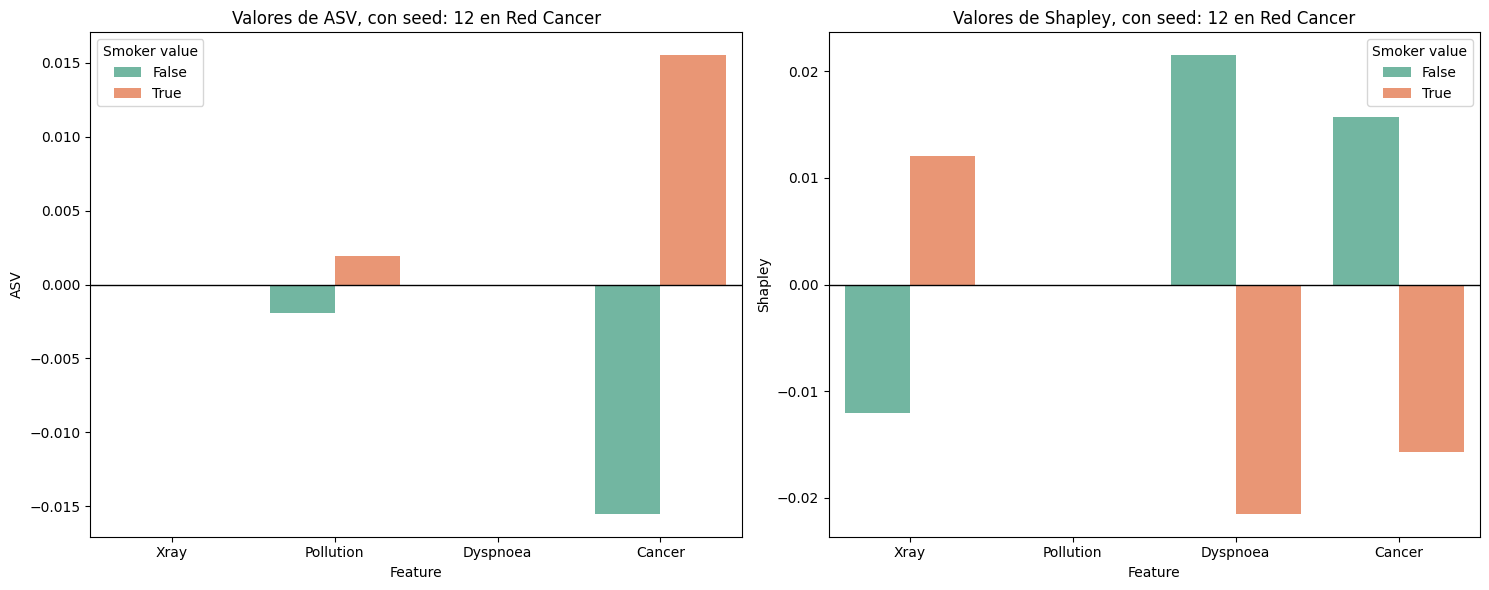

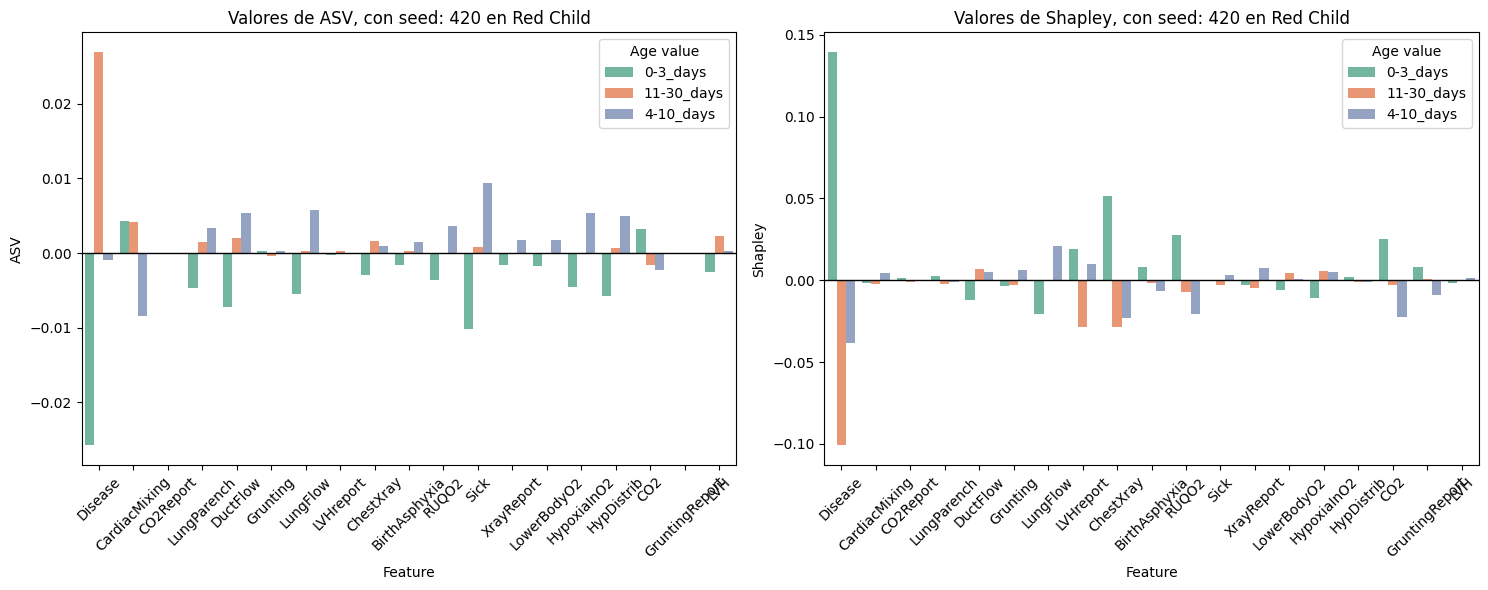

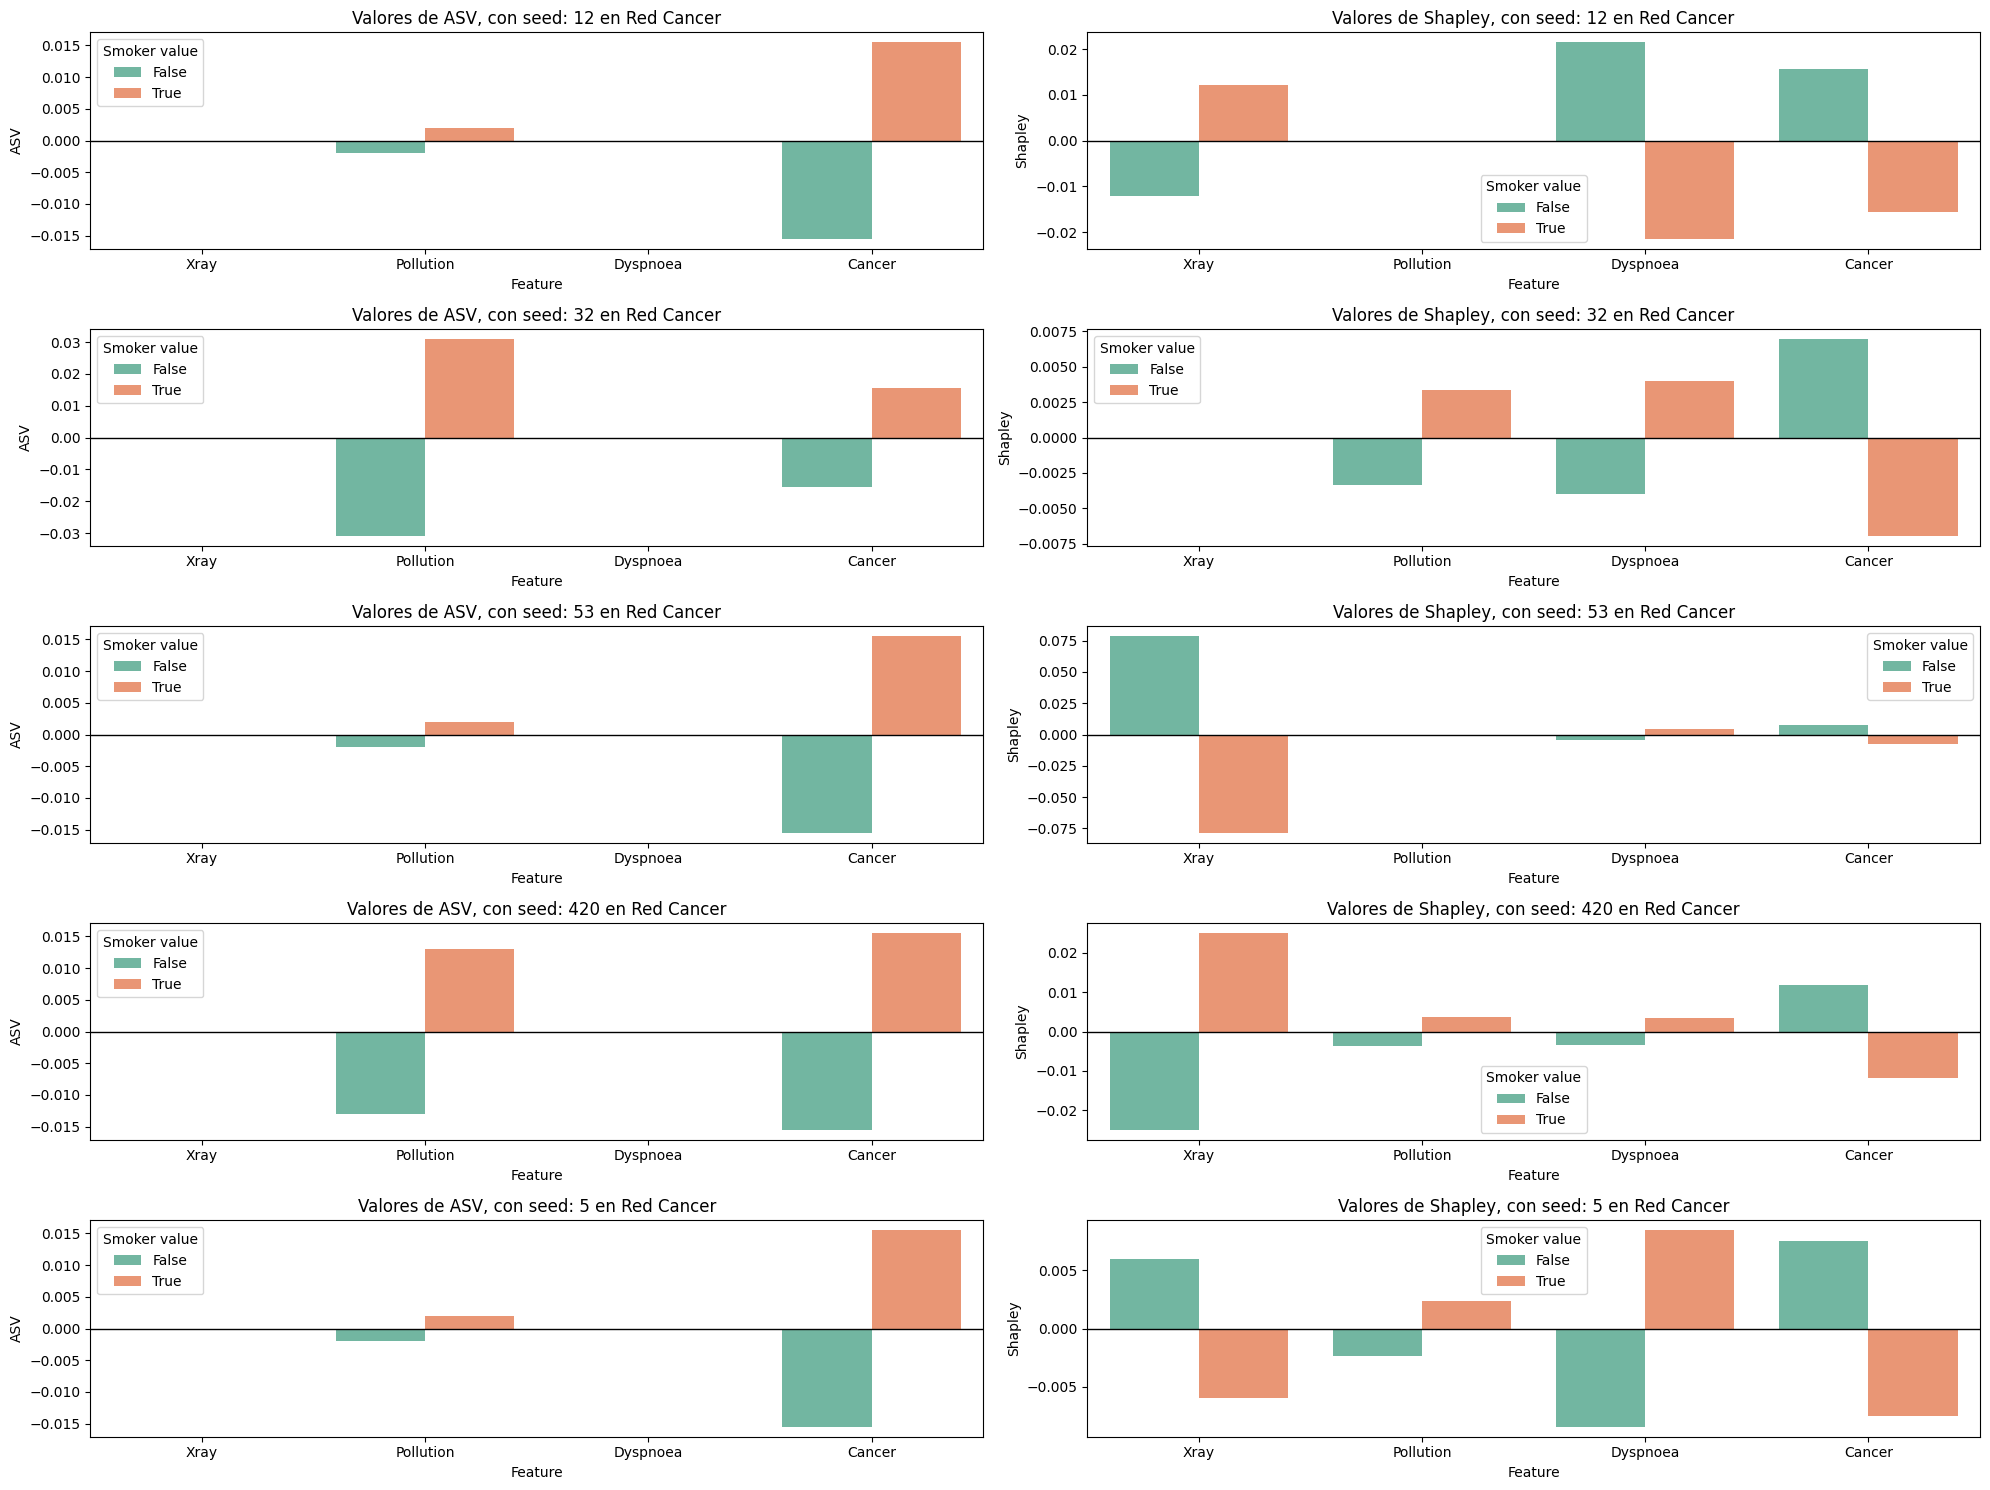

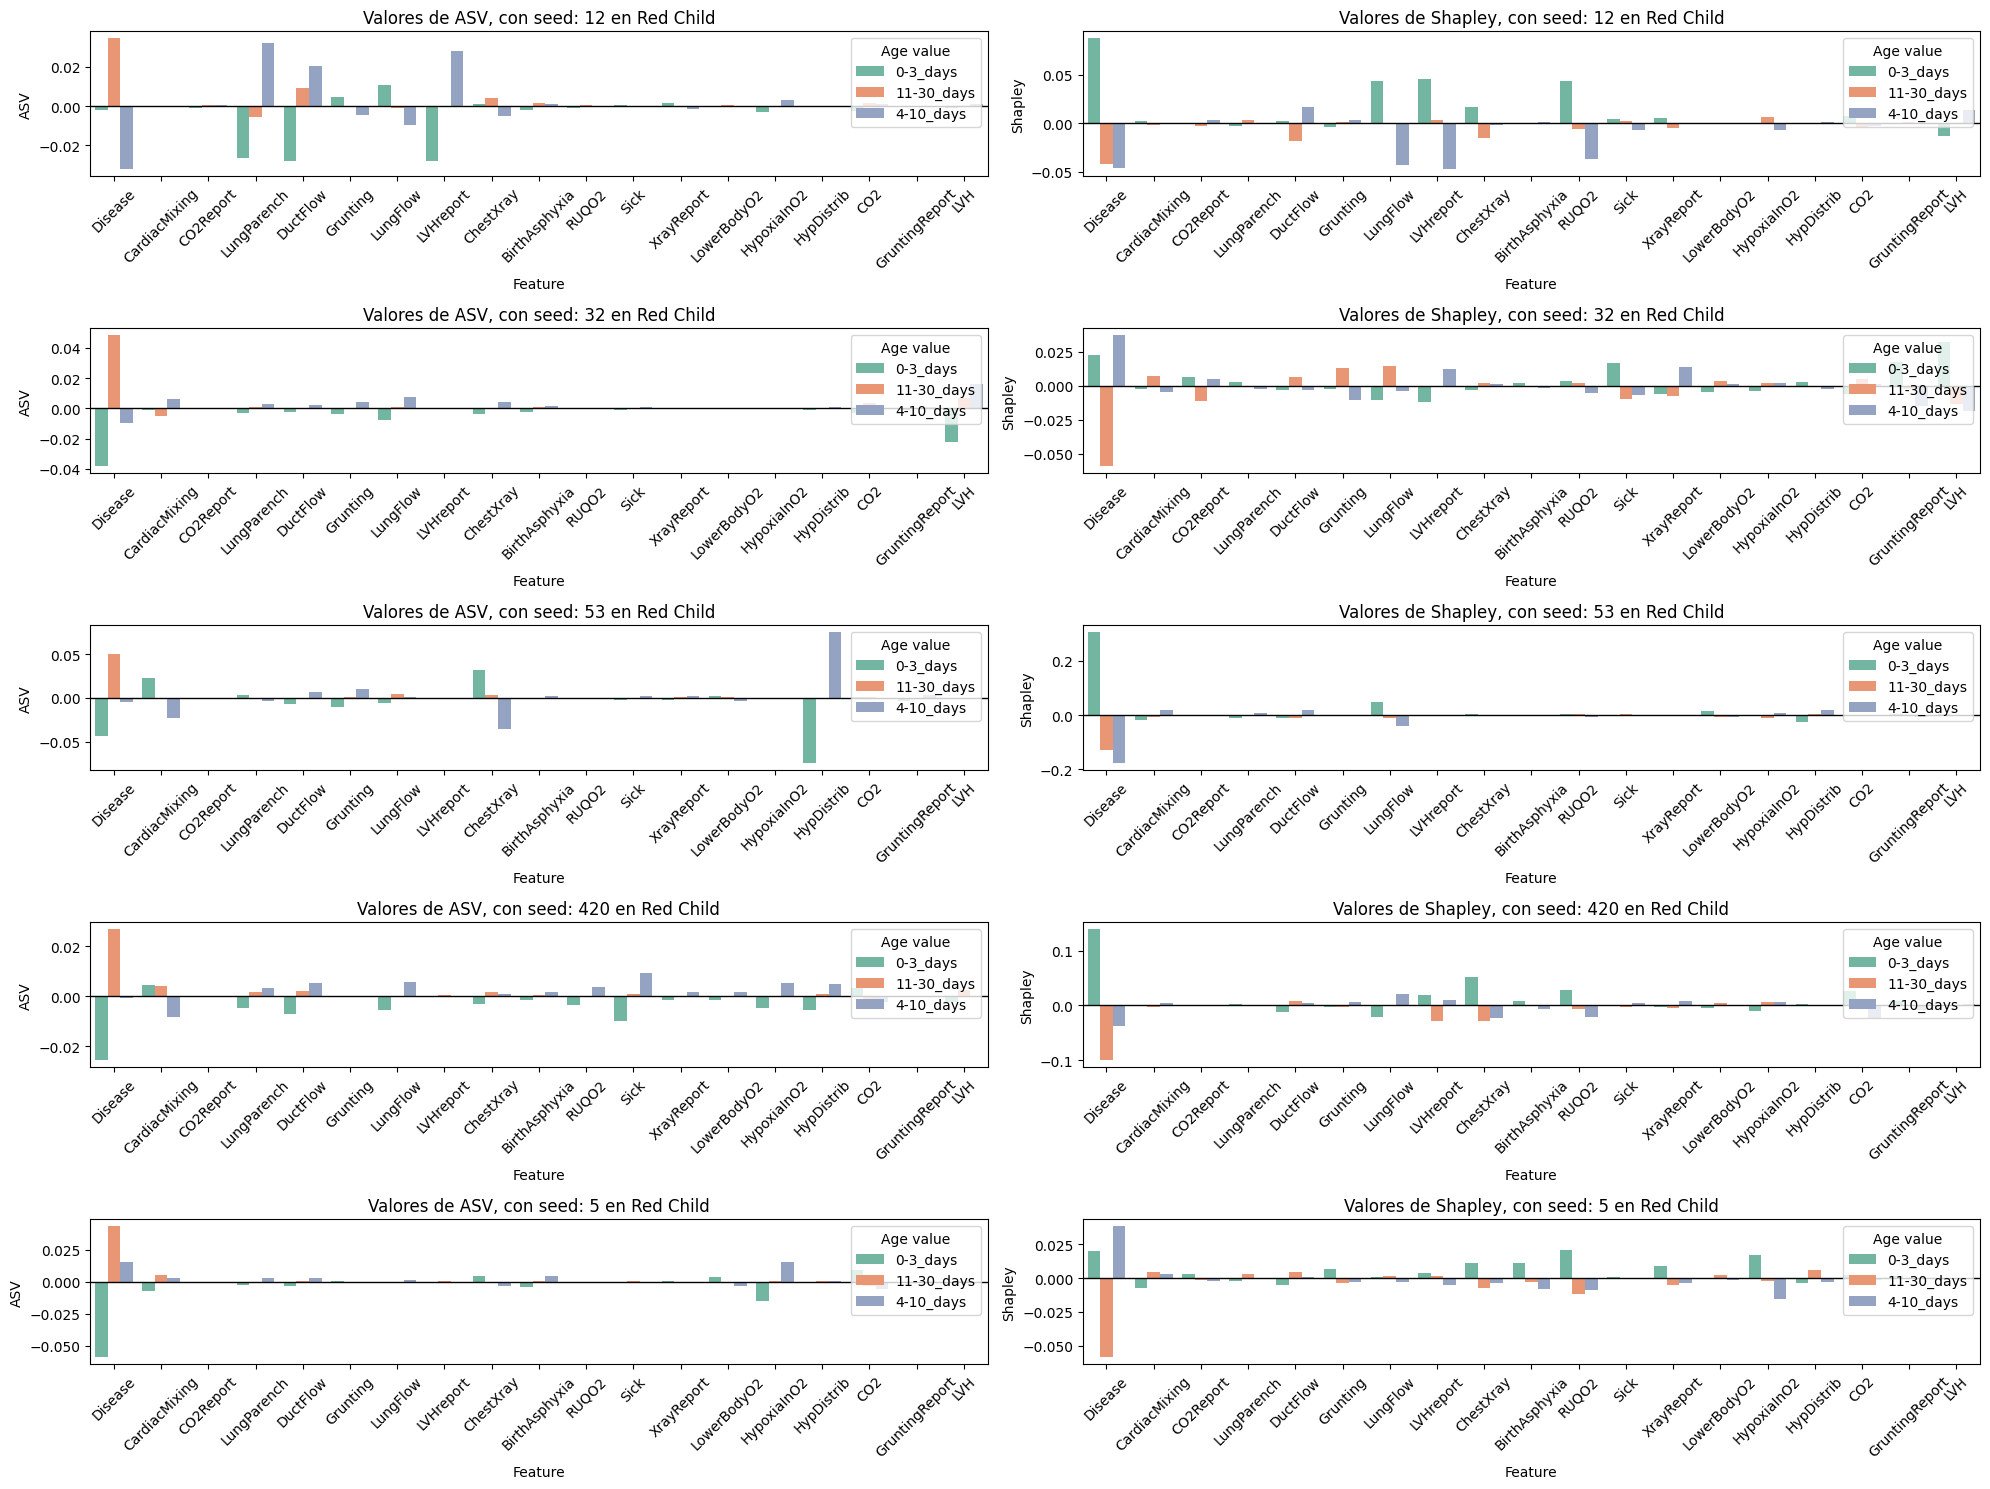

In [10]:
plotsResultsFolder = 'results/plots/'

def plotASVandShapForSeeds(seeds, dfDict, hueValue):
    _, axes = plt.subplots(len(seeds), 2, figsize=(20, 15))
    for i, seed in enumerate(seeds):
        df = dfDict[seed]
        exp.plotASVandShapFromDF(df, hueValue, seed, None, axes[i])

    bayesianNetwork = 'cancer' if "Smoker value" == hueValue else 'child'
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"{plotsResultsFolder}{bayesianNetwork}MultipleSeedsASVandShapley.png")
    plt.show()

exp.plotASVandShapFromDF(dfCancerExactDict[12], 'Smoker value', 12, f"{plotsResultsFolder}{dfCancerExactDict[12].name}ASVAndShapley.png")
exp.plotASVandShapFromDF(dfChildExactDict[420], 'Age value', 420, f"{plotsResultsFolder}{dfChildExactDict[420].name}ASVAndShapley.png")

seeds = [12,32,53,420,5]

plotASVandShapForSeeds(seeds, dfCancerExactDict, 'Smoker value')
plotASVandShapForSeeds(seeds, dfChildExactDict, 'Age value')


## Analyzing Networks Probabilities

In [ ]:
from pgmpy.readwrite import BIFReader
from asvFormula.bayesianNetworks import networkSamplesPath
import pandas as pd
from pgmpy.inference import VariableElimination
import itertools

cancerNetworkPath = networkSamplesPath + "/cancer.bif"
completeCancerBNModel = BIFReader(cancerNetworkPath).get_model()

childNetworkPath = networkSamplesPath + "/child.bif"
completeChildBNModel = BIFReader(childNetworkPath).get_model()

In [ ]:
def possibleStatesFor(variable, bnModel):
    return bnModel.get_cpds(variable).state_names[variable]

# Function to add query results and compute differences
def add_query_rows(variable, values, variableToPredict, rows, bnModel):
    state_names = possibleStatesFor(variableToPredict, bnModel)
    probs = {state_val: {} for state_val in state_names}
    predictedProbColumn = f"phi({variableToPredict})"
    infer = VariableElimination(bnModel)

    predicted_prob = infer.query(variables=[variableToPredict])

    for val in values:
        result = infer.query(variables=[variableToPredict], evidence={variable: val})
        for i, state_val in enumerate(state_names):
            original_prob = predicted_prob.get_value(**{variableToPredict: state_val})
            prob = round(result.values[i], 4)
            probs[state_val][val] = prob

            rows.append({
                "Variable": variable,
                "Variable value" : val,
                variableToPredict: state_val,
                predictedProbColumn : prob,
                "Probability Shift" : round(abs(prob - original_prob), 4)
            })

def obtainProbabilityShifts(bnModel, variableToPredict):
    rows = []
    variables = list(bnModel.nodes)
    variables.remove(variableToPredict)
    for variable in variables:
        add_query_rows(variable, possibleStatesFor(variable, bnModel), variableToPredict, rows, bnModel)

    df = pd.DataFrame(rows)
    return df

cancerDf = obtainProbabilityShifts(completeCancerBNModel, "Smoker")
childDf = obtainProbabilityShifts(completeChildBNModel, "Age")

resultsFolder = "results/probabilityShifts/"
cancerDf.to_csv(resultsFolder + "cancerProbabilityShifts.csv")
childDf.to_csv(resultsFolder + "childProbabilityShifts.csv")



In [8]:
from pgmpy.readwrite import BIFReader
from asvFormula.bayesianNetworks import networkSamplesPath
import pandas as pd
from pgmpy.inference import VariableElimination
import itertools

cancerNetworkPath = networkSamplesPath + "/cancer.bif"
completeCancerBNModel = BIFReader(cancerNetworkPath).get_model()

childNetworkPath = networkSamplesPath + "/child.bif"
completeChildBNModel = BIFReader(childNetworkPath).get_model()

In [9]:
def possibleStatesFor(variable, bnModel):
    return bnModel.get_cpds(variable).state_names[variable]

# Function to add query results and compute differences
def add_query_rows(variable, values, variableToPredict, rows, bnModel):
    state_names = possibleStatesFor(variableToPredict, bnModel)
    probs = {state_val: {} for state_val in state_names}
    predictedProbColumn = f"phi({variableToPredict})"
    infer = VariableElimination(bnModel)

    predicted_prob = infer.query(variables=[variableToPredict])

    for val in values:
        result = infer.query(variables=[variableToPredict], evidence={variable: val})
        for i, state_val in enumerate(state_names):
            original_prob = predicted_prob.get_value(**{variableToPredict: state_val})
            prob = round(result.values[i], 4)
            probs[state_val][val] = prob

            rows.append({
                "Variable": variable,
                "Variable value" : val,
                variableToPredict: state_val,
                predictedProbColumn : prob,
                "Probability Shift" : round(abs(prob - original_prob), 4)
            })

def obtainProbabilityShifts(bnModel, variableToPredict):
    rows = []
    variables = list(bnModel.nodes)
    variables.remove(variableToPredict)
    for variable in variables:
        add_query_rows(variable, possibleStatesFor(variable, bnModel), variableToPredict, rows, bnModel)

    df = pd.DataFrame(rows)
    return df

cancerDf = obtainProbabilityShifts(completeCancerBNModel, "Smoker")
childDf = obtainProbabilityShifts(completeChildBNModel, "Age")

resultsFolder = "results/probabilityShifts/"
cancerDf.to_csv(resultsFolder + "cancerProbabilityShifts.csv")
childDf.to_csv(resultsFolder + "childProbabilityShifts.csv")



## Analyzing Pollution ASV Values

In [5]:
seed = 101
cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth = exp.cancerNetworkConfig()
BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth, seed)

dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
first_instance = dataNoPrediction.iloc[0]

asvCalc = exact.ASV(cancerBNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

cancerASVTestingFile = asvRunResultsPath + "/childASVAndShapleyApproximateTesting.csv"

dataSet = dataNoPrediction.copy()
progress = False

  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.775


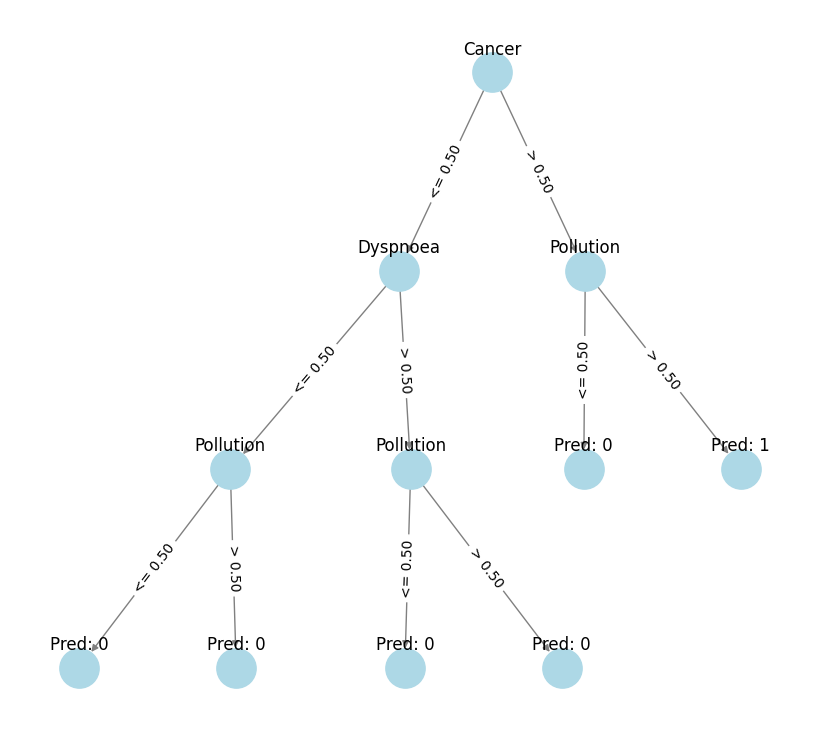

In [6]:
drawDecisionTree(dtAsNetwork)

In [4]:
import shap

features = list(dataSet.columns)
explainer = shap.TreeExplainer(dtTreeClassifier, dataSet)
shap_values = explainer.shap_values(first_instance)
predictionValues = valuesPerFeature[variableToPredict]

cancerASVTestingFile = asvRunResultsPath + "/childASVAndShapleyApproximateTesting.csv"

# Check if the file exists to decide whether to write the header
file_exists = os.path.isfile(cancerASVTestingFile)

os.remove(cancerASVTestingFile) if file_exists else None  # Remove the file to reset results

with open(cancerASVTestingFile, 'a') as f:
    if not file_exists:
        f.write(f"Feature,{variableToPredict} value,ASV,Shapley,Seed\n")

    for i, feature in enumerate(features):
        asvValue = asvCalc.asvForFeature(feature, first_instance, showProgress=progress)
        shapleyValue = shap_values[i]
        for j in range(len(shapleyValue)):
            f.write(f"{feature},{predictionValues[j]},{asvValue[j]},{shapleyValue[j]},{seed}\n")